In [1]:
import tensorboard


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional, Flatten, Input, Lambda, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text 
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertModel, BertConfig
import numpy as np
import string
import pandas as pd
import os

c:\Users\USER\anaconda3\envs\research\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv('../Data/improvedds_new.csv')

In [4]:
model_ans_col = 'Model_Answer'
ans_col = 'Answer'
label_col = 'Category'

In [5]:
def preprocess_data_for_model_training(df, model_ans_col='Model_Answer', ans_col='Answer'):
    """
    Preprocess data
    """
    print("Preprocessing data...")
    df[model_ans_col] = data[model_ans_col].apply(lambda x: str(x).lower())
    df[ans_col] = data[ans_col].apply(lambda x: str(x).lower())

    df[model_ans_col] = df[model_ans_col].apply(lambda x: x.strip())
    df[ans_col] = df[ans_col].apply(lambda x: x.strip())

    df[model_ans_col] = df[model_ans_col].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    df[ans_col] = df[ans_col].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

    print("Data preprocessing is done")
    return df


In [6]:
# split data for deep learning model training and testing
X_train, X_test, y_train, y_test = train_test_split(
    data[[model_ans_col, ans_col, 'LengthRatio', 'Cosine_Similarity']], data[label_col], test_size=0.2, random_state=176)

# convert to one-hot encoding
y_train = to_categorical(y_train, num_classes=None)
y_test = to_categorical(y_test, num_classes=None)


In [7]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

In [8]:
embedding_model = tf.keras.Model(text_input, sequence_output)

In [9]:
# Define Input Layers
input_model_answer = Input(shape=(1,), dtype=tf.string)
input_answer = Input(shape=(1,), dtype=tf.string)
input_text_features = Input(shape=(2,) , dtype=tf.float32)

In [10]:
embedding_model_answer = embedding_model(input_model_answer)
embedding_answer = embedding_model(input_answer)

In [11]:
# get the differnce of the embedding vectors
diff_model_ans = Lambda(
        lambda x: x[0] - x[1])([embedding_model_answer, embedding_answer])

In [12]:
# apply the LSTM layer
lstm_model_answer = Bidirectional(
    LSTM(50, return_sequences=True))(diff_model_ans)

lstm_answer = Bidirectional(
    LSTM(50, return_sequences=True))(embedding_answer)


In [13]:
# apply dropout
dropout_model_answer = Dropout(0.2)(lstm_model_answer)
dropout_answer = Dropout(0.2)(lstm_answer)

In [14]:
# apply the Dense layer
dense_model_answer = Dense(100, activation='relu')(dropout_model_answer)
dense_answer = Dense(100, activation='relu')(dropout_answer)

In [15]:
feature_layer = Dense(100, activation='relu')(input_text_features)

In [16]:
# concatenate the outputs
concatenate_model_answer = concatenate([dense_model_answer, dense_answer])

In [17]:
# apply Dense layer
dense_model1 = Dense(50, activation='relu')(concatenate_model_answer)

# # apply dropout
dropout_model1 = Dropout(0.2)(dense_model1)

In [18]:
# reduce the dimensionality
dense_model2 = Dense(25, activation='relu')(dense_model1)

In [19]:
# include Flatten layer
flatten_model_answer = Flatten()(dense_model2)

In [20]:
concat_layer = concatenate([flatten_model_answer, feature_layer])

In [21]:
final_layer = Dense(10, activation='relu')(concat_layer)

In [22]:
# apply Dense layer - output layer
output_model_answer = Dense(3, activation='softmax')(final_layer)

In [23]:
# create the model
model = Model(inputs=[input_model_answer, input_answer, input_text_features], outputs=output_model_answer)

In [24]:
# compile the model
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.00001), metrics=['accuracy'])

c:\Users\USER\anaconda3\envs\research\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
# define class weights according to the number of samples in each class
num_samples_class_0 = len(X_train[y_train[:, 0] == 1])
num_samples_class_1 = len(X_train[y_train[:, 1] == 1])
num_samples_class_2 = len(X_train[y_train[:, 2] == 1])


class_weights = {0: num_samples_class_0 / (num_samples_class_0 + num_samples_class_1 + num_samples_class_2),
                    1: num_samples_class_1 / (num_samples_class_0 + num_samples_class_1 + num_samples_class_2),                                                     
                    2: num_samples_class_2 / (num_samples_class_0 + num_samples_class_1 + num_samples_class_2)}     

In [26]:
from tensorflow.keras.callbacks import TensorBoard
import time

# logs about the training process
# accuracy and loss are plotted in the TensorBoard
log_dir = "logs/fit/" + str(int(time.time()))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [27]:
# fit the model
history = model.fit([X_train[model_ans_col], X_train[ans_col], X_train[['LengthRatio', 'Cosine_Similarity']]], y_train, epochs=50, batch_size=32,
              validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5), tensorboard_callback], class_weight=class_weights)

Epoch 1/50
790/790 [==============================] - 770s 959ms/step - loss: 0.3144 - accuracy: 0.5444 - val_loss: 0.9112 - val_accuracy: 0.6246
Epoch 2/50
790/790 [==============================] - 756s 956ms/step - loss: 0.2210 - accuracy: 0.6615 - val_loss: 0.8101 - val_accuracy: 0.6898
Epoch 3/50
790/790 [==============================] - 753s 953ms/step - loss: 0.1928 - accuracy: 0.7111 - val_loss: 0.7377 - val_accuracy: 0.7231
Epoch 4/50
790/790 [==============================] - 739s 936ms/step - loss: 0.1711 - accuracy: 0.7423 - val_loss: 0.6465 - val_accuracy: 0.7551
Epoch 5/50
790/790 [==============================] - 751s 951ms/step - loss: 0.1526 - accuracy: 0.7640 - val_loss: 0.5920 - val_accuracy: 0.7687
Epoch 6/50
790/790 [==============================] - 752s 951ms/step - loss: 0.1370 - accuracy: 0.7780 - val_loss: 0.5300 - val_accuracy: 0.7852
Epoch 7/50
790/790 [==============================] - 749s 948ms/step - loss: 0.1226 - accuracy: 0.7942 - val_loss: 0.4821 -

In [28]:
# evaluate the model
scores = model.evaluate(
        [X_train[model_ans_col], X_train[ans_col], X_train[['LengthRatio', 'Cosine_Similarity']]], y_train, verbose=0)

print("Accuracy: %.2f%%" % (scores[1]*100))
print("Loss: %.2f" % scores[0])


Accuracy: 99.84%
Loss: 0.01


In [29]:
print("Test Accuracy: %.2f%%" % (model.evaluate(
        [X_test[model_ans_col], X_test[ans_col], np.asarray(X_test[['LengthRatio', 'Cosine_Similarity']]).astype(np.float32)], y_test, verbose=1)[1]*100))

247/247 [==============================] - 183s 722ms/step - loss: 0.0230 - accuracy: 0.9951
Test Accuracy: 99.51%


In [30]:
BERT_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4" # @param {type: "string"} ["https://tfhub.dev/google/experts/bert/wiki_books/2", "https://tfhub.dev/google/experts/bert/wiki_books/mnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qqp/2", "https://tfhub.dev/google/experts/bert/wiki_books/squad2/2", "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2",  "https://tfhub.dev/google/experts/bert/pubmed/2", "https://tfhub.dev/google/experts/bert/pubmed/squad2/2"]
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [31]:
preprocess = hub.load(PREPROCESS_MODEL)
bert = hub.load(BERT_MODEL)

In [32]:
from sklearn.metrics import pairwise

In [33]:
def calCosineSimilarity(model_ans, ans):
    model_ans_embed = bert(preprocess([model_ans]))["pooled_output"]
    ans_embed = bert(preprocess([ans]))["pooled_output"]

    cosine_sim = pairwise.cosine_similarity(model_ans_embed, ans_embed)
    print(cosine_sim)

    return cosine_sim[0]

In [39]:
model_ans_p = "When the array is sorted in the ascending order"
ans_p = "Ascending Order Sorted Array"

def get_length_ration(model_ans, ans):
    return len(ans)/len(model_ans)

cosine_similarity_p = calCosineSimilarity(model_ans_p, ans_p)
length_ration_p = get_length_ration(model_ans_p, ans_p)

testdf = pd.DataFrame(columns=['Model_Answer', 'Answer', 'LengthRatio', 'Cosine_Similarity'])
testdf.loc[0] = [model_ans_p, ans_p, length_ration_p, cosine_similarity_p]

prediction = model.predict([testdf[model_ans_col].iloc[0:1], testdf[ans_col].iloc[0:1], np.asarray(testdf[['LengthRatio', 'Cosine_Similarity']].iloc[0:1]).astype(np.float32)])
print("Category:", np.argmax(prediction))

[[0.92474294]]
Category: 1


In [40]:
# save the model
import datetime
isSave = 'y'

if isSave == 'y':
    model.save('./Models/model0522.h5')
    print("Model saved")

Model saved


In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

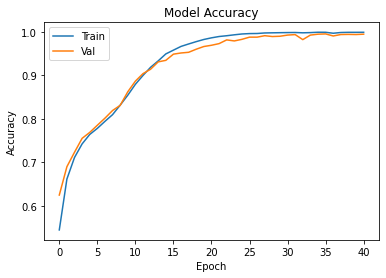

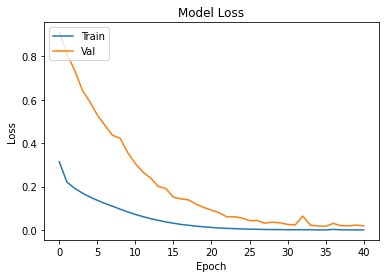

In [42]:
# plot the training histroy of the deep learning model
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

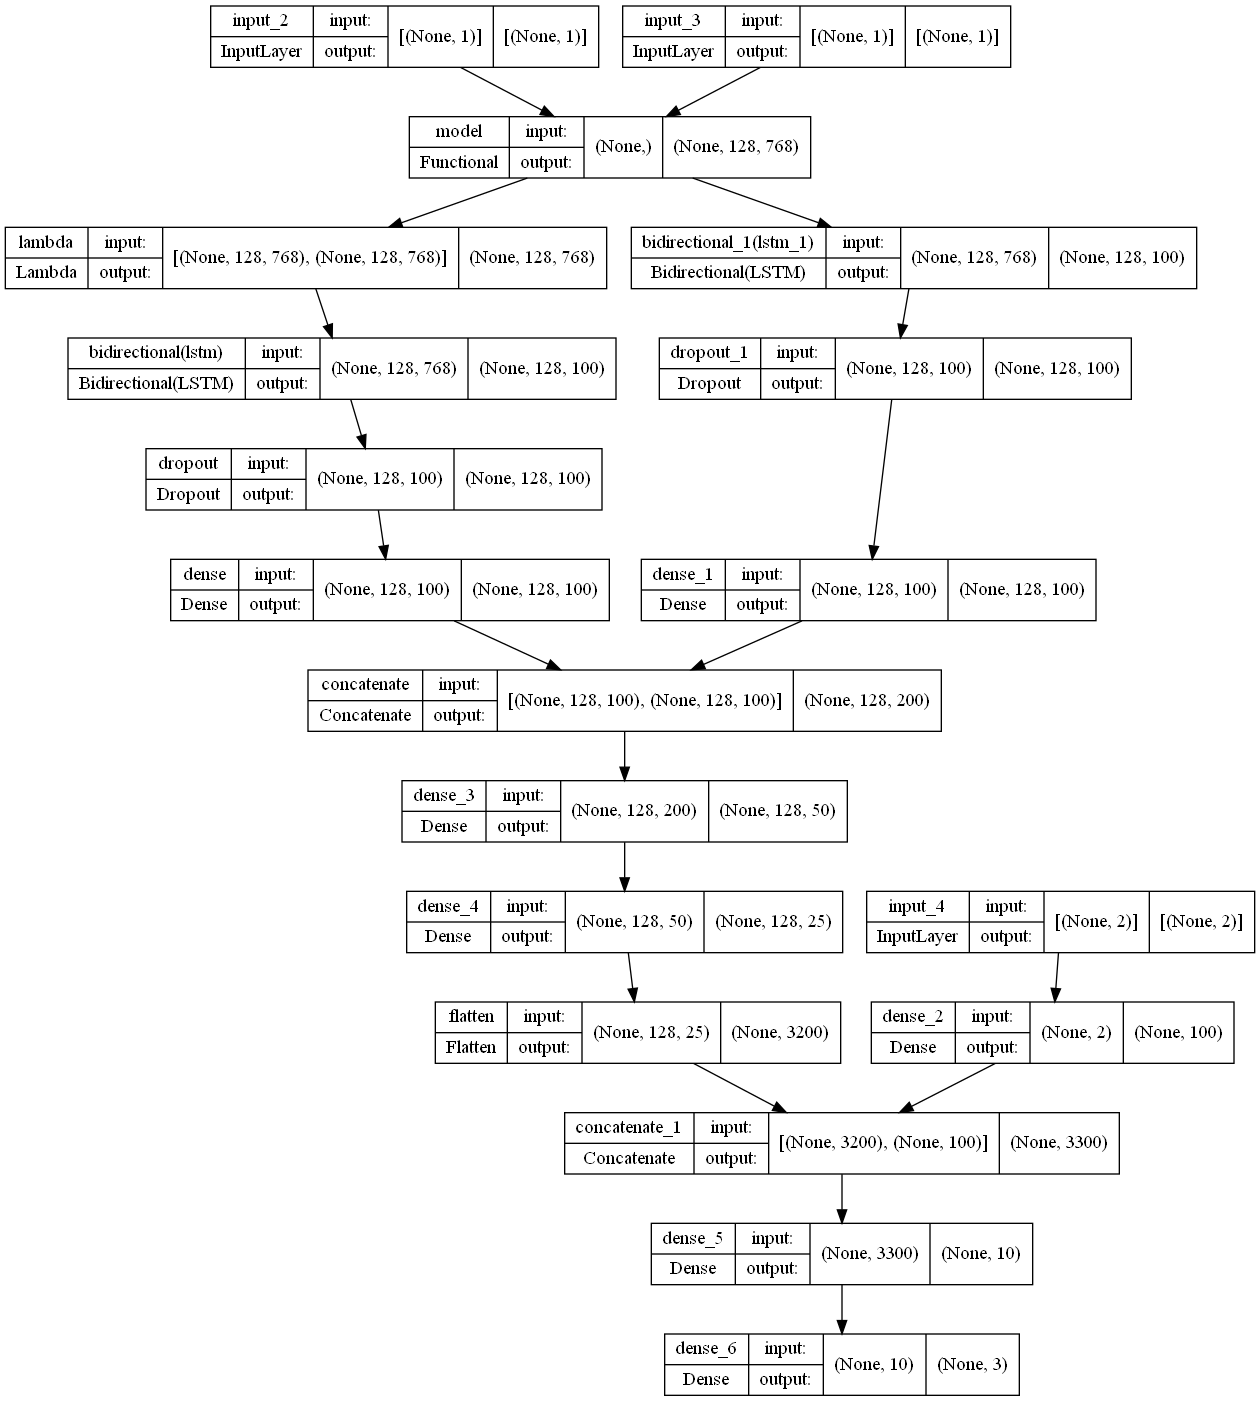

In [43]:
# plot the model structure
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='./model_structure.png', show_shapes=True)


In [ ]:
from keras.models import load_model
my_reloaded_model = tf.keras.models.load_model(('./Models/model.h5'),custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
from keras.utils.vis_utils import plot_model
import pydot

In [ ]:
# PLOT the structure of the model
plot_model(my_reloaded_model, to_file='./model_structure_reloaded.png', show_shapes=True)

In [ ]:
my_reloaded_model.summary()